<a href="https://colab.research.google.com/github/MehrdadJalali-AI/BlackHole/blob/main/BlackHoleMethod_Updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# Mount drive
from google.colab import drive
import os

drive.mount('/content/drive')
# Change working path
os.chdir('/content/drive/MyDrive/Research/MOF/Black_Hole/Implementation/Data')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 36.0 MB/s eta 0:00:00


Initial number of communities: 847
Initial number of nodes: 12561

Processing for threshold: 0
Number of nodes before applying Black Hole Strategy for threshold 0: 12561
Number of nodes after applying Black Hole Strategy with threshold 0: 12561
Extended features of the remaining nodes saved to Node_features_blackhole_0.csv


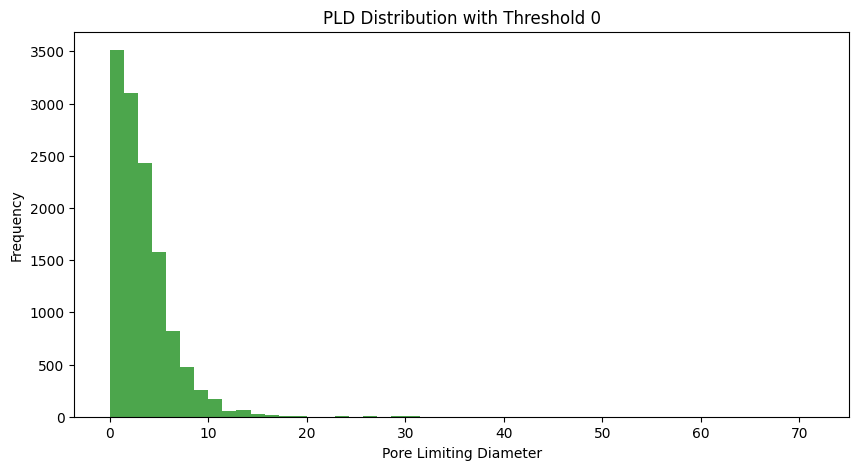


Processing for threshold: 0.1
Number of nodes before applying Black Hole Strategy for threshold 0.1: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.1: 11100
Extended features of the remaining nodes saved to Node_features_blackhole_0.1.csv


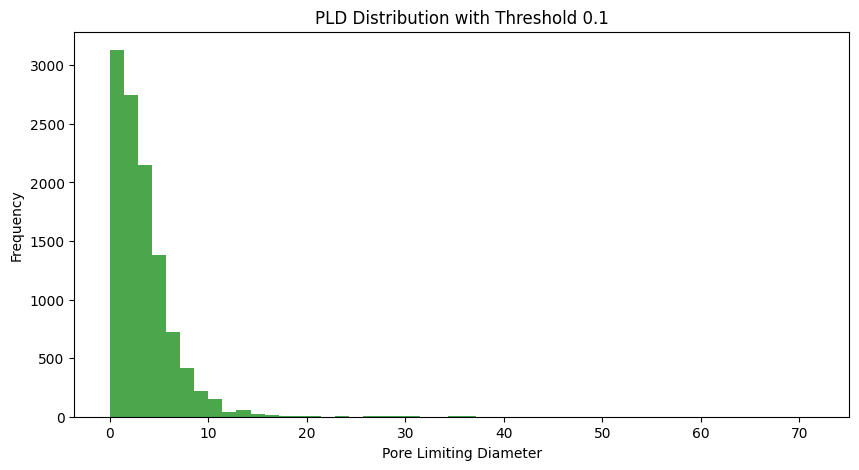


Processing for threshold: 0.2
Number of nodes before applying Black Hole Strategy for threshold 0.2: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.2: 10168
Extended features of the remaining nodes saved to Node_features_blackhole_0.2.csv


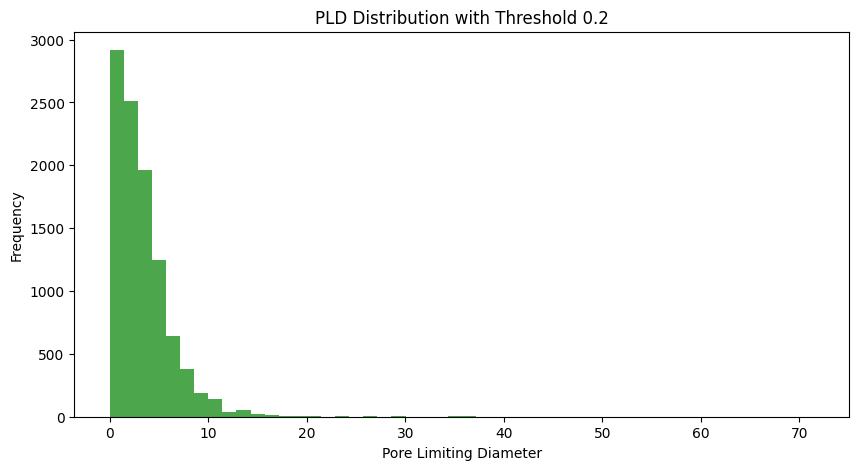


Processing for threshold: 0.3
Number of nodes before applying Black Hole Strategy for threshold 0.3: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.3: 9246
Extended features of the remaining nodes saved to Node_features_blackhole_0.3.csv


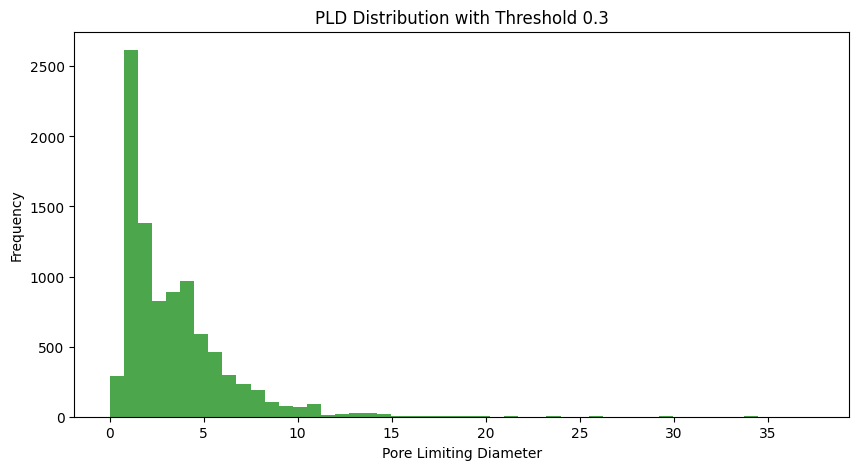


Processing for threshold: 0.4
Number of nodes before applying Black Hole Strategy for threshold 0.4: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.4: 8290
Extended features of the remaining nodes saved to Node_features_blackhole_0.4.csv


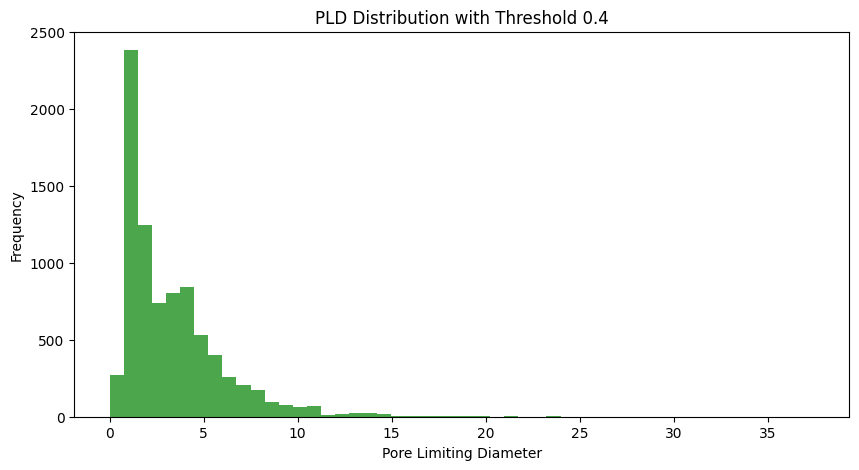


Processing for threshold: 0.5
Number of nodes before applying Black Hole Strategy for threshold 0.5: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.5: 7406
Extended features of the remaining nodes saved to Node_features_blackhole_0.5.csv


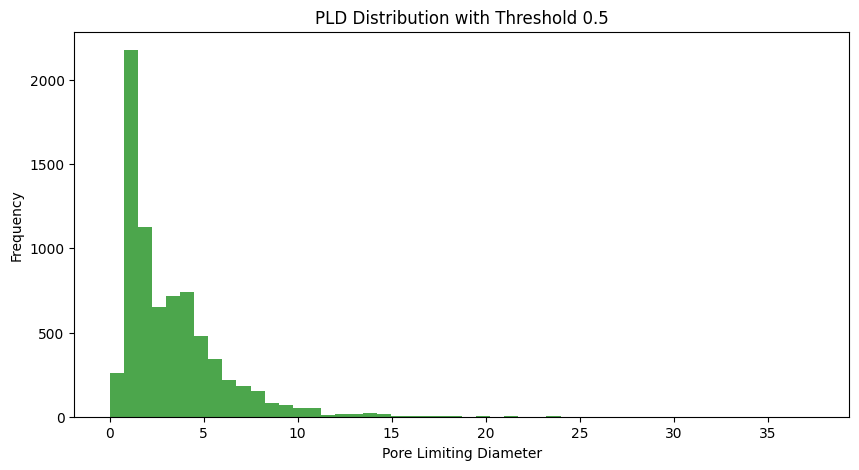


Processing for threshold: 0.6
Number of nodes before applying Black Hole Strategy for threshold 0.6: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.6: 6462
Extended features of the remaining nodes saved to Node_features_blackhole_0.6.csv


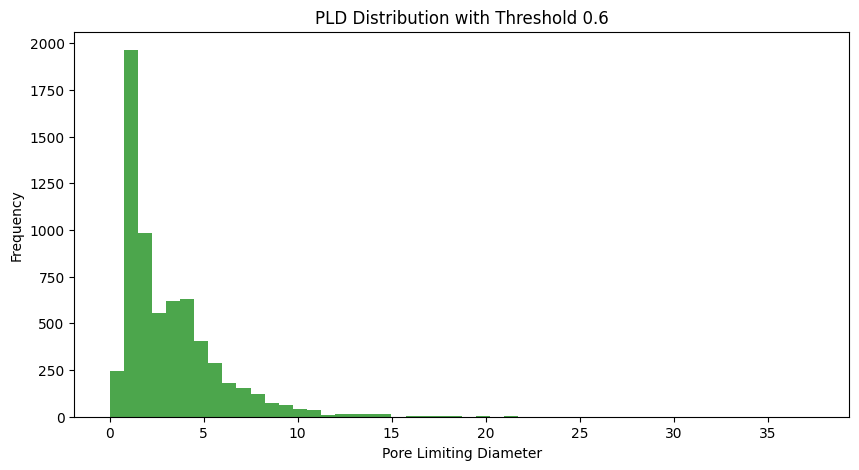


Processing for threshold: 0.7
Number of nodes before applying Black Hole Strategy for threshold 0.7: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.7: 5607
Extended features of the remaining nodes saved to Node_features_blackhole_0.7.csv


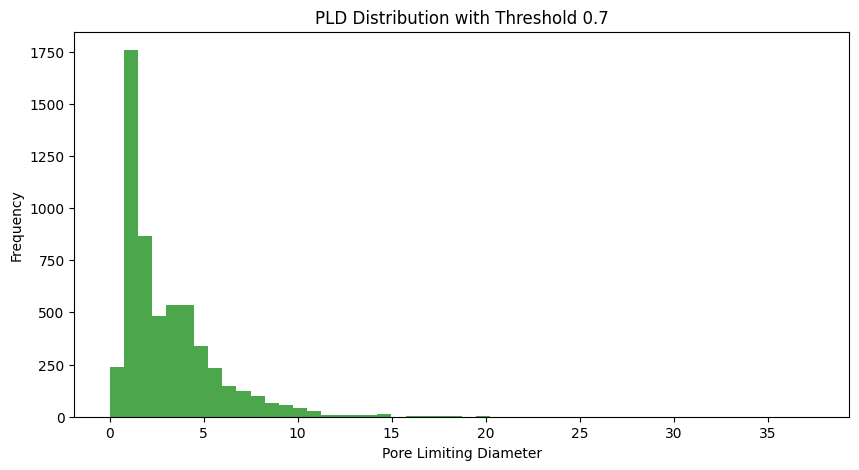


Processing for threshold: 0.8
Number of nodes before applying Black Hole Strategy for threshold 0.8: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.8: 4735
Extended features of the remaining nodes saved to Node_features_blackhole_0.8.csv


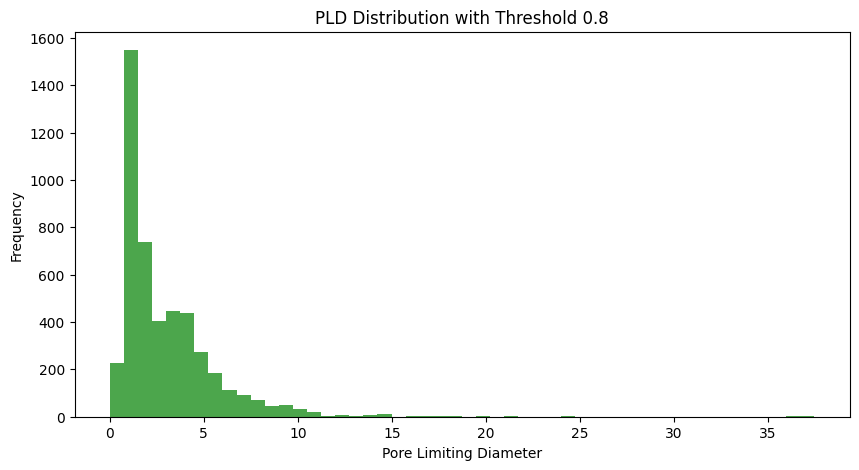


Processing for threshold: 0.9
Number of nodes before applying Black Hole Strategy for threshold 0.9: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.9: 4008
Extended features of the remaining nodes saved to Node_features_blackhole_0.9.csv


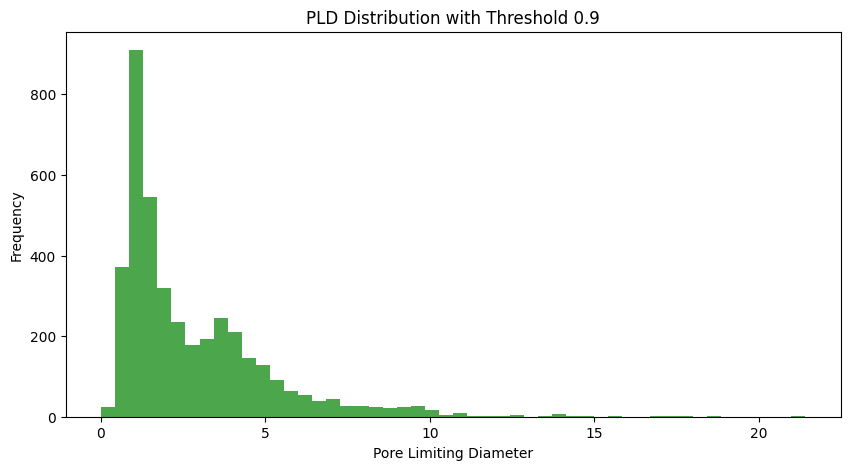


Processing for threshold: 0.95
Number of nodes before applying Black Hole Strategy for threshold 0.95: 12561
Number of nodes after applying Black Hole Strategy with threshold 0.95: 3748
Extended features of the remaining nodes saved to Node_features_blackhole_0.95.csv


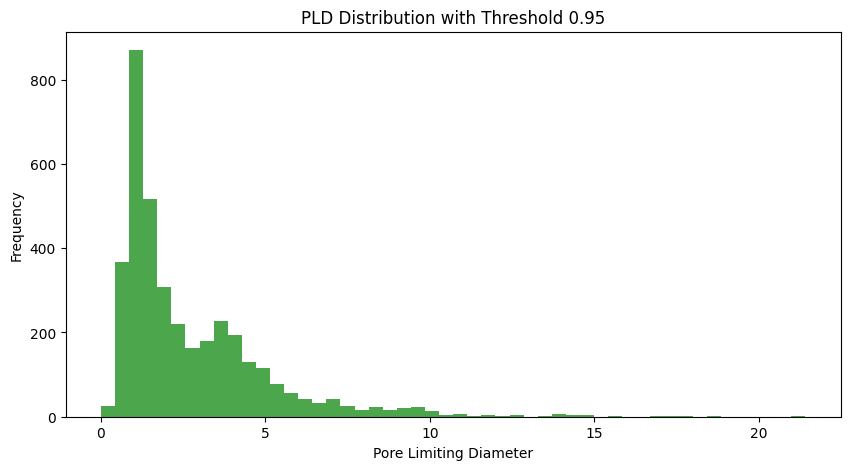

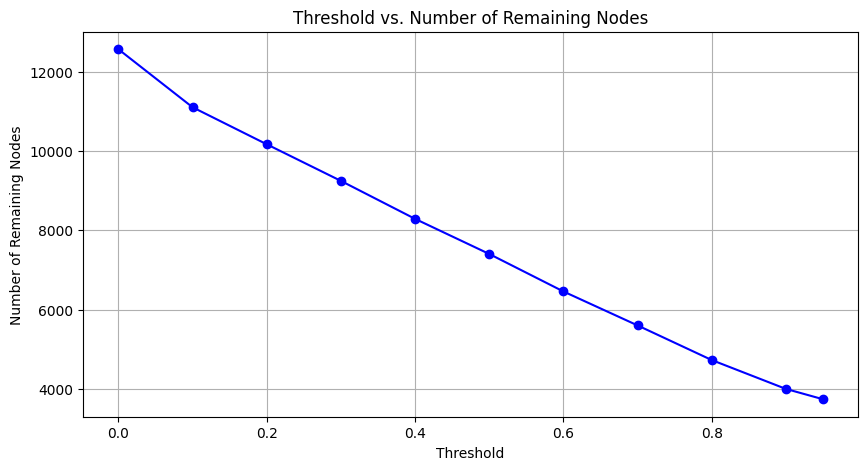

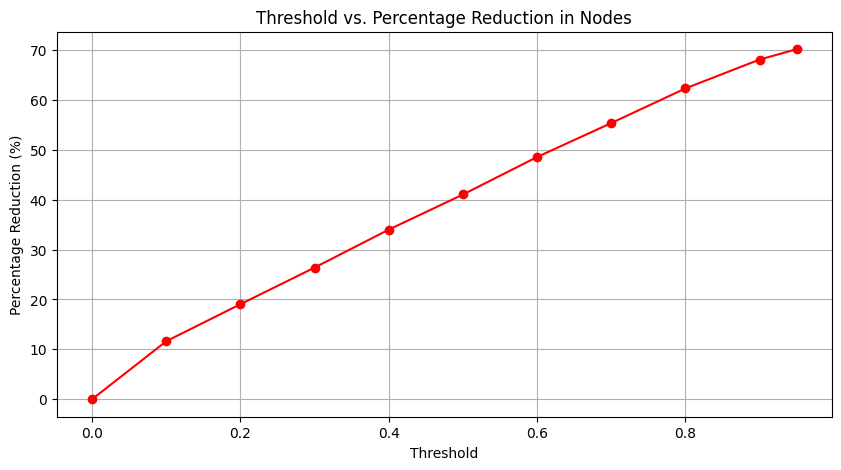

Total runtime: 11992.237533092499 seconds


In [10]:
import warnings
warnings.filterwarnings("ignore")  # Suppress warnings
from rdkit import RDLogger
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
import matplotlib.pyplot as plt
import networkx.algorithms.community as nx_comm
import time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.cm as cm

# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')

def load_edges_list(filename):
    """Loads edge list from a CSV file."""
    edges_list = pd.read_csv(filename)
    # Ensure the necessary columns exist
    required_columns = {'source', 'target', 'weight'}
    if not required_columns.issubset(edges_list.columns):
        raise ValueError(f"The edges list file must contain the columns: {required_columns}")
    return edges_list

def load_summary_data(filename, node_labels):
    """Loads summary data and ensures alignment with node labels."""
    summary_data = pd.read_csv(filename)
    # Ensure that 'refcode' is the column containing node labels
    if 'refcode' in summary_data.columns:
        summary_data.set_index('refcode', inplace=True)
    else:
        raise ValueError("The summary data file does not contain a 'refcode' column.")
    # Ensure the index aligns with node labels
    summary_data = summary_data.loc[node_labels]
    return summary_data

def detect_communities(graph):
    """Detects communities in the graph using the Girvan-Newman algorithm."""
    communities_generator = nx_comm.girvan_newman(graph)
    top_level_communities = next(communities_generator)
    return [list(community) for community in top_level_communities]

def assign_community_ids(communities):
    """Assigns a unique ID to each community."""
    community_ids = {}
    for i, community in enumerate(communities):
        for node in community:
            community_ids[node] = i
    return community_ids

def calculate_gravity_per_community(graph, communities):
    """Calculates normalized gravity per community."""
    community_gravity = {}
    degree_centrality = {}
    betweenness_centrality = {}
    edge_weight_sum = {}

    for community in communities:
        subgraph = graph.subgraph(community)
        degree_centrality_community = nx.degree_centrality(subgraph)
        betweenness_centrality_community = nx.betweenness_centrality(subgraph, normalized=True)
        edge_weight_sum_community = {node: sum(data['weight'] for _, _, data in subgraph.edges(node, data=True)) for node in subgraph.nodes()}

        # Convert values to arrays for normalization
        degree_values = list(degree_centrality_community.values())
        betweenness_values = list(betweenness_centrality_community.values())
        weight_sum_values = list(edge_weight_sum_community.values())

        # Normalize within the community
        scaler = MinMaxScaler()
        normalized_degree = scaler.fit_transform(np.array(degree_values).reshape(-1, 1)).flatten()
        normalized_betweenness = scaler.fit_transform(np.array(betweenness_values).reshape(-1, 1)).flatten()
        normalized_weight_sum = scaler.fit_transform(np.array(weight_sum_values).reshape(-1, 1)).flatten()

        # Assign normalized values and calculate gravity for each node in the community
        for idx, node in enumerate(community):
            degree = normalized_degree[idx]
            betweenness = normalized_betweenness[idx]
            weight_sum = normalized_weight_sum[idx]

            # Gravity is the average of the normalized metrics
            gravity = (degree + betweenness + weight_sum) / 3
            community_gravity[node] = gravity
            degree_centrality[node] = degree_centrality_community[node]
            betweenness_centrality[node] = betweenness_centrality_community[node]
            edge_weight_sum[node] = edge_weight_sum_community[node]

    return community_gravity, degree_centrality, betweenness_centrality, edge_weight_sum

def black_hole_strategy_combined(graph, summary_data, gravity_scores, communities, threshold):
    """Combines gravity metrics with stratified sampling to preserve PLD distribution."""
    if threshold == 0.0:
        return graph  # Return the original graph without any changes.

    nodes_to_remove = []

    for community in communities:
        community_nodes = [node for node in community if node in graph.nodes()]
        community_pld = summary_data.loc[community_nodes, 'Pore Limiting Diameter'].to_frame()
        community_pld['Gravity'] = [gravity_scores.get(node, 0) for node in community_nodes]

        # Determine the number of nodes to keep
        num_nodes = len(community_nodes)
        num_to_keep = int((1 - threshold) * num_nodes)

        if num_to_keep <= 0:
            # If threshold is too high, keep at least one node
            num_to_keep = 1

        # Create bins for PLD values
        num_bins = min(10, num_nodes)  # Choose an appropriate number of bins
        community_pld['PLD_bin'] = pd.qcut(community_pld['Pore Limiting Diameter'], q=num_bins, duplicates='drop')

        # Initialize list to collect nodes to keep
        nodes_to_keep = []

        # Perform stratified sampling within bins, prioritizing nodes with higher gravity scores
        for pld_bin, bin_group in community_pld.groupby('PLD_bin'):
            bin_nodes = bin_group.index.tolist()
            bin_size = len(bin_nodes)
            bin_num_to_keep = max(1, int((num_to_keep / num_nodes) * bin_size))

            # Sort nodes in the bin by gravity score in descending order
            bin_group_sorted = bin_group.sort_values(by='Gravity', ascending=False)

            # Select top nodes based on gravity scores
            sampled_nodes = bin_group_sorted.head(bin_num_to_keep).index.tolist()
            nodes_to_keep.extend(sampled_nodes)

        # Identify nodes to remove
        nodes_to_remove_in_community = set(community_nodes) - set(nodes_to_keep)
        nodes_to_remove.extend(nodes_to_remove_in_community)

    graph.remove_nodes_from(nodes_to_remove)
    return graph

def save_extended_node_features(graph, original_summary_filename, gravity, degree_centrality, betweenness_centrality, edge_weight_sum, community_ids, filename):
    """Saves extended node features including gravity metrics and community IDs."""
    remaining_nodes = list(graph.nodes())

    # Load the original summary data without any modification
    original_summary_data = pd.read_csv(original_summary_filename)
    if 'refcode' in original_summary_data.columns:
        original_summary_data.set_index('refcode', inplace=True)
    else:
        raise ValueError("The summary data file does not contain a 'refcode' column.")

    # Ensure we keep only the rows corresponding to the remaining nodes
    original_summary_data = original_summary_data.loc[original_summary_data.index.isin(remaining_nodes)]

    # Create a DataFrame for the new features
    metrics_data = pd.DataFrame({
        'refcode': remaining_nodes,
        'Community ID': [community_ids.get(node, -1) for node in remaining_nodes],
        'Gravity': [gravity.get(node, 0) for node in remaining_nodes],
        'Degree Centrality': [degree_centrality.get(node, 0) for node in remaining_nodes],
        'Betweenness Centrality': [betweenness_centrality.get(node, 0) for node in remaining_nodes],
        'Edge Weight Sum': [edge_weight_sum.get(node, 0) for node in remaining_nodes],
    })

    # Set 'refcode' as the index for merging
    metrics_data.set_index('refcode', inplace=True)

    # Merge the original summary data with the new metrics data
    final_data = pd.concat([original_summary_data, metrics_data], axis=1)
    final_data.index.name = 'refcode'

    # Save the result to the specified file
    final_data.to_csv(filename, index=True)
    print(f"Extended features of the remaining nodes saved to {filename}")

def visualize_pld_distribution(summary_data, graph, title):
    """Visualizes the distribution of PLD values in the graph."""
    # Ensure that we are using the correct node labels to index the DataFrame
    node_list = list(graph.nodes())

    try:
        pld_values = summary_data.loc[node_list, 'Pore Limiting Diameter']
    except KeyError:
        raise KeyError("Some node labels in the graph are not found in the summary_data DataFrame.")

    # Plotting the PLD distribution
    plt.figure(figsize=(10, 5))
    plt.hist(pld_values.dropna(), bins=50, color='g', alpha=0.7)  # Handle missing values
    plt.title(title)
    plt.xlabel('Pore Limiting Diameter')
    plt.ylabel('Frequency')
    plt.show()

if __name__ == "__main__":
    start_time = time.time()
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    edges_list_filename = 'edges_list_0.8_Full_2.csv'
    # edges_list_filename = 'edges_list_short.csv'
    summary_data_filename = '1M1L3D_summary.csv'

    # Load edge list and node labels
    edges_list = load_edges_list(edges_list_filename)
    node_labels = pd.concat([edges_list['source'], edges_list['target']]).unique()

    # Load the summary data
    summary_data = load_summary_data(summary_data_filename, node_labels)

    # Construct the graph
    graph = nx.Graph()
    for _, row in edges_list.iterrows():
        graph.add_edge(row['source'], row['target'], weight=row['weight'])

    # Detect initial communities
    initial_communities = detect_communities(graph)
    community_ids = assign_community_ids(initial_communities)  # Get community IDs

    # Get the initial number of nodes
    initial_num_nodes = graph.number_of_nodes()
    print(f"Initial number of communities: {len(initial_communities)}")
    print(f"Initial number of nodes: {initial_num_nodes}")

    # Lists to store results for plotting
    nodes_remaining = []
    percentage_reduction = []

    for threshold in thresholds:
        print(f"\nProcessing for threshold: {threshold}")

        # Reset the graph for each threshold
        graph = nx.Graph()
        for _, row in edges_list.iterrows():
            graph.add_edge(row['source'], row['target'], weight=row['weight'])

        # Calculate gravity metrics
        gravity_per_community, degree_centrality, betweenness_centrality, edge_weight_sum = calculate_gravity_per_community(graph, initial_communities)

        # Number of nodes before applying the Black Hole Strategy at this threshold
        num_nodes_before = graph.number_of_nodes()
        print(f"Number of nodes before applying Black Hole Strategy for threshold {threshold}: {num_nodes_before}")

        # Apply the Black Hole Strategy combining gravity and stratified sampling
        graph = black_hole_strategy_combined(graph, summary_data, gravity_per_community, initial_communities, threshold)

        # Number of nodes after applying the Black Hole Strategy
        num_nodes_after = graph.number_of_nodes()
        print(f"Number of nodes after applying Black Hole Strategy with threshold {threshold}: {num_nodes_after}")

        # Store the number of remaining nodes and percentage reduction
        nodes_remaining.append(num_nodes_after)
        percentage_reduction.append(((initial_num_nodes - num_nodes_after) / initial_num_nodes) * 100)

        # Save the results
        output_edges_filename = f'Edges_blackhole_{threshold}.csv'
        output_features_filename = f'Node_features_blackhole_{threshold}.csv'
        nx.write_edgelist(graph, output_edges_filename, data=['weight'])

        # Save extended node features with community IDs included
        save_extended_node_features(
            graph, summary_data_filename, gravity_per_community, degree_centrality,
            betweenness_centrality, edge_weight_sum, community_ids, output_features_filename
        )

        # Visualize PLD distribution
        visualize_pld_distribution(summary_data, graph, title=f'PLD Distribution with Threshold {threshold}')

    # Plot Threshold vs Number of Remaining Nodes
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, nodes_remaining, marker='o', color='b')
    plt.title("Threshold vs. Number of Remaining Nodes")
    plt.xlabel("Threshold")
    plt.ylabel("Number of Remaining Nodes")
    plt.grid(True)
    plt.show()

    # Plot Threshold vs Percentage Reduction in Nodes
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, percentage_reduction, marker='o', color='r')
    plt.title("Threshold vs. Percentage Reduction in Nodes")
    plt.xlabel("Threshold")
    plt.ylabel("Percentage Reduction (%)")
    plt.grid(True)
    plt.show()

    print(f"Total runtime: {time.time() - start_time} seconds")


# Black Hole Strategy for MOF Graphs

In this notebook, we are implementing a **Black Hole Strategy** to refine the graph representation of Metal-Organic Frameworks (MOFs). This approach helps us reduce the complexity of the graph by identifying and removing less influential nodes (MOFs) based on a calculated "gravity" metric. The steps involved in this strategy are as follows:

## 1. Loading the Edge List and Summary Data
We begin by loading the edge list, which defines the relationships (edges) between MOFs (nodes), and the summary data, which contains additional features about the MOFs (such as chemical properties).

- **Edge List**: Contains source and target nodes (MOFs) and their connection weights.
- **Summary Data**: Contains features for each MOF, such as SMILES strings, metal types, and geometric properties like cavity diameter and pore size.

## 2. Constructing the MOF Graph
Using the edge list, we create a graph where each node represents a MOF, and edges represent the relationships between them. This graph allows us to explore the structure and connectivity of the MOFs.

## 3. Detecting Communities
To organize the graph, we apply **community detection**. Communities represent groups of MOFs that are more strongly connected to each other than to other parts of the graph.

- **Girvan-Newman Algorithm**: This algorithm is used to detect communities by iteratively removing edges with high betweenness centrality, splitting the graph into smaller groups.

## 4. Calculating the Gravity Metric
Within each detected community, we calculate a **gravity metric** for each node. This metric combines two centrality measures:
- **Degree Centrality**: Represents how many connections (edges) a node has.
- **Betweenness Centrality**: Represents how often a node acts as a bridge between other nodes in the graph.

The gravity of a node is the sum of its degree and betweenness centrality. Nodes with higher gravity are considered more influential within their communities.

## 5. Applying the Black Hole Strategy
In the Black Hole Strategy, we set a gravity threshold. Nodes (MOFs) with gravity below this threshold are considered less influential and are removed from the graph, along with their associated edges. This results in a "sparsified" graph containing only the most important nodes (black holes) within each community.

## 6. Saving the Sparsified Graph and Features
After removing low-gravity nodes, we save the new edge list of the sparsified graph and the features of the remaining nodes for further analysis. This refined dataset focuses on the most promising MOFs and simplifies future computations.

## 7. Visualizing the Graph
Finally, we visualize the sparsified graph to observe the structure after applying the Black Hole Strategy. The visualization helps us see how the graph has been reduced in complexity and highlights the key communities and their central nodes.

## Benefits of the Black Hole Strategy:
- **Efficiency**: By focusing on the most influential MOFs, we reduce the dataset size and computational cost for further analysis.
- **Clarity**: The resulting graph highlights the most important MOFs, making it easier to identify key candidates for specific applications.


## Influential Node Detection in Network Communities

To identify the most influential nodes within each community in a network, we employ a comprehensive strategy that combines several centrality measures with the connectivity strength of each node. This approach helps in pinpointing nodes that not only hold strategic positions but are also highly connected, thereby playing a crucial role in the structure and dynamics of their communities.

### Methodology

1. **Degree Centrality**: Measures the number of direct connections a node has. Nodes with a high degree centrality can influence their immediate neighbors more significantly.

2. **Betweenness Centrality**: Captures the extent to which a node lies on the shortest path between other nodes in the network. Nodes with high betweenness centrality can control the flow of information within the network, acting as critical conduits between different parts of the network.

3. **Edge Weight Sum**: Reflects the total weight of all edges connected to a node, emphasizing the 'strength' or 'value' of its connections.

### Normalization Strategy

Each of the above metrics is normalized by their maximum values in the subgraph of each community to ensure a fair comparison across diverse network scales and topologies. The final 'gravity' score of each node is then calculated as the sum of these normalized values, providing a single metric to assess the relative influence of nodes within their respective communities.


# Black Hole Strategy for Graph Sparsification

The **Black Hole Strategy** is a graph sparsification technique that progressively removes less important nodes from the graph while retaining the structurally crucial ones. The importance of nodes is quantified by a "gravity" score, which is computed based on multiple centrality metrics. This method ensures that the most central and influential nodes within each community are preserved, while the less connected or influential nodes are removed.

## 1. Community Detection

The first step in the Black Hole Strategy is to partition the graph into disjoint communities. This is done using the Girvan-Newman algorithm, which iteratively removes the edges with the highest betweenness centrality until communities are formed. Each community represents a subgraph of the original graph.

Mathematically, the graph \( G \) is divided into communities \( C_1, C_2, \dots, C_k \), where each community \( C_i \) is a subgraph of \( G \).

\[
C = \{C_1, C_2, \dots, C_k\}, \quad \text{where} \ C_i \subseteq G
\]

## 2. Gravity Calculation

For each node \( v \) in a community \( C_i \), three centrality metrics are calculated to determine its influence within the community:

- **Degree Centrality** \( d(v) \): This measures the number of direct connections a node has, normalized by the number of possible connections.
  
  \[
  d(v) = \frac{\text{deg}(v)}{|C_i| - 1}
  \]

- **Betweenness Centrality** \( b(v) \): This measures how often a node lies on the shortest paths between other nodes in the community.
  
  \[
  b(v) = \frac{ \sum_{s,t \in C_i} \sigma_{st}(v)}{\sigma_{st}}, \quad \text{where} \ \sigma_{st} \ \text{is the number of shortest paths from} \ s \ \text{to} \ t
  \]

- **Edge Weight Sum** \( w(v) \): This metric captures the total weight of edges connected to the node.

  \[
  w(v) = \sum_{(v, u) \in E_i} \text{weight}(v, u), \quad \text{where} \ E_i \ \text{is the set of edges in community} \ C_i
  \]

These three metrics are normalized within each community using **Min-Max Normalization**. The gravity \( g(v) \) of a node is then calculated as the average of the normalized centrality scores:

\[
g(v) = \frac{d'(v) + b'(v) + w'(v)}{3}
\]

Where \( d'(v), b'(v), \text{and } w'(v) \) are the normalized degree, betweenness, and weight sum centralities, respectively.

## 3. Node Removal Based on Gravity

The Black Hole Strategy iteratively removes nodes based on their gravity score. The user defines a threshold \( T \) that controls the proportion of nodes to retain in each community. For example:
- A threshold of \( T = 0.1 \) retains the top 90% of nodes (with the highest gravity) and removes the remaining 10%.
- A threshold of \( T = 0.2 \) retains the top 80% of nodes, and so on.

For each community \( C_i \), the nodes are sorted by their gravity scores in descending order, and the number of nodes to keep is calculated as:

\[
\text{Nodes to Keep} = \lceil (1 - T) \times |C_i| \rceil
\]

Nodes with the lowest gravity are removed, and the graph is updated by removing both the nodes and their associated edges.

## 4. Graph Update

After node removal, the graph \( G \) is updated to reflect the remaining nodes and their edges. The sparsified graph consists of nodes with the highest gravity, ensuring that the structural integrity and centrality of the graph are preserved while reducing its complexity.

## 5. Algorithm Summary

The Black Hole Strategy can be summarized as follows:
1. Partition the graph \( G \) into communities using the Girvan-Newman algorithm.
2. For each node \( v \in C_i \), compute the degree centrality, betweenness centrality, and edge weight sum.
3. Normalize the centrality metrics within each community.
4. Calculate the gravity of each node as the average of the normalized centrality metrics.
5. Remove nodes with the lowest gravity based on a user-defined threshold \( T \).
6. Update the graph by removing the selected nodes and their edges.

By applying the Black Hole Strategy, the graph is progressively sparsified while preserving its most critical nodes, allowing for more efficient analysis and processing of large-scale networks.


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import warnings
from rdkit import RDLogger
# Suppress specific deprecation warnings and RDKit warnings globally
warnings.filterwarnings("ignore", category=DeprecationWarning)
RDLogger.DisableLog('rdApp.*')
def generate_fingerprint(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024), dtype=float)
        return np.zeros((1024,), dtype=float)
    except Exception as e:
        print(f"SMILES Parse Error: {e}")
        return np.zeros((1024,), dtype=float)
def label_encode_metal_names(metal_names):
    metal_dict = {metal: idx for idx, metal in enumerate(np.unique(metal_names))}
    return np.array([metal_dict[metal] for metal in metal_names])
# Optimize GCN training with TensorFlow's data pipeline
def build_gcn_model(input_shape_feature, input_shape_adjacency, num_classes):
    x_inp_feature = Input(shape=(input_shape_feature,))
    x_inp_adjacency = Input(shape=(input_shape_adjacency,))

    # Feature Network
    x_feature = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_inp_feature)
    x_feature = Dropout(0.5)(x_feature)
    x_feature = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_feature)

    # Adjacency Network
    x_adjacency = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_inp_adjacency)
    x_adjacency = Dropout(0.5)(x_adjacency)
    x_adjacency = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x_adjacency)

    # Concatenate features and adjacency data
    x = concatenate([x_feature, x_adjacency])
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[x_inp_feature, x_inp_adjacency], outputs=output)
    model.compile(optimizer=Adam(learning_rate=0.0009), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Function to read edge files dynamically based on threshold
def load_edges_and_summary(threshold):
    edge_file = f"Edges_blackhole_{threshold}.csv"
    summary_file = '1M1L3D_summary.csv'

    # Read edge list
    edges_list = pd.read_csv(edge_file, delimiter=' ', header=None, names=['source', 'target', 'weight'])

    # Read summary data
    summary_data = pd.read_csv(summary_file)

    return edges_list, summary_data

def preprocess_graph(graph, features):
    feature_dimension = features.shape[1]
    adjacency_matrix = nx.adjacency_matrix(graph).toarray()
    node_to_index = {node: index for index, node in enumerate(graph.nodes())}

    feature_vectors = [features[node_to_index[node]] if node in node_to_index else np.zeros((feature_dimension,)) for node in graph.nodes()]
    feature_matrix = np.array(feature_vectors)

    return adjacency_matrix, feature_matrix

def train_gcn_model(model, adj_train, feat_train, y_train, epochs, batch_size):
    # Use TensorFlow's data pipeline for faster training
    dataset = tf.data.Dataset.from_tensor_slices(((feat_train, adj_train), y_train))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Use early stopping to avoid overfitting
    early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

    model.fit(dataset, epochs=epochs, callbacks=[early_stopping])
def build_feedforward_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dropout(0.5),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model
def build_and_evaluate_models(X_train, X_test, y_train, y_test, adj_train, feat_train, accuracies, threshold):
    num_classes = y_train.shape[1]

    # Build and train GCN model
    gcn_model = build_gcn_model(feat_train.shape[1], adj_train.shape[1], num_classes)
    train_gcn_model(gcn_model, adj_train, feat_train, y_train, epochs=10, batch_size=32)
    gcn_acc = gcn_model.evaluate([feat_test, adj_test], y_test, verbose=0)[1]
    accuracies['GCN'].append(gcn_acc)

    # Build and train KNN model
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, np.argmax(y_train, axis=1))
    knn_acc = accuracy_score(np.argmax(y_test, axis=1), knn_model.predict(X_test))
    accuracies['KNN'].append(knn_acc)

    # Build and train Naive Bayes model
    nb_model = GaussianNB()
    nb_model.fit(X_train, np.argmax(y_train, axis=1))
    nb_acc = accuracy_score(np.argmax(y_test, axis=1), nb_model.predict(X_test))
    accuracies['Naive Bayes'].append(nb_acc)

    # Build and train Gradient Boosting model
    gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
    gb_model.fit(X_train, np.argmax(y_train, axis=1))
    gb_acc = accuracy_score(np.argmax(y_test, axis=1), gb_model.predict(X_test))
    accuracies['Gradient Boosting'].append(gb_acc)

    # Build and train DNN model
    dnn_model = build_feedforward_model(X_train.shape[1], num_classes)
    dnn_model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_split=0.2)
    dnn_acc = dnn_model.evaluate(X_test, y_test, verbose=0)[1]
    accuracies['DNN'].append(dnn_acc)

    print(f"Accuracies for threshold {threshold}: GCN={gcn_acc}, KNN={knn_acc}, Naive Bayes={nb_acc}, Gradient Boosting={gb_acc}, DNN={dnn_acc}")

if __name__ == "__main__":
    thresholds = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
    accuracies = {'GCN': [], 'KNN': [], 'Naive Bayes': [], 'Gradient Boosting': [], 'DNN': []}

    for threshold in thresholds:
        print(f"Processing threshold: {threshold}")
        edges_list, summary_data = load_edges_and_summary(threshold)

        node_labels_source = edges_list['source'].astype(str).unique()
        node_labels_target = edges_list['target'].astype(str).unique()
        node_labels = np.unique(np.concatenate((node_labels_source, node_labels_target)))

        summary_data_filtered = summary_data[summary_data['refcode'].isin(node_labels)]
        if not summary_data_filtered.empty:
            linker_smiles = summary_data_filtered['linker SMILES']
            if not linker_smiles.empty:
                linker_features = np.stack(linker_smiles.dropna().apply(generate_fingerprint).values)
                metal_names = summary_data_filtered['metal']
                metal_features = label_encode_metal_names(metal_names).reshape(-1, 1)
                other_features = summary_data_filtered[['Largest Cavity Diameter', 'Largest Free Sphere']].values.astype('float32')
                features = np.concatenate((linker_features, metal_features, other_features), axis=1)

                summary_data_filtered['PLD_category'] = pd.cut(
                    summary_data_filtered['Pore Limiting Diameter'],
                    bins=[-np.inf, 2.4, 4.4, 5.9, np.inf],
                    labels=['nonporous', 'small pore', 'medium pore', 'large pore']
                )
                labels = pd.get_dummies(summary_data_filtered['PLD_category']).values

                X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=56)
                graph = nx.read_weighted_edgelist(f"Edges_blackhole_{threshold}.csv")

                adjacency_matrix, feature_matrix = preprocess_graph(graph, features)
                adj_train, adj_test, feat_train, feat_test = train_test_split(adjacency_matrix, feature_matrix, test_size=0.2, random_state=56)

                build_and_evaluate_models(X_train, X_test, y_train, y_test, adj_train, feat_train, accuracies, threshold)
            else:
                print("Error: linker_smiles column is empty.")
        else:
            print("Error: summary_data_filtered DataFrame is empty.")



    plt.figure(figsize=(10, 6))
    for model_name, model_accuracies in accuracies.items():
        plt.plot(thresholds, model_accuracies, marker='o', label=f'{model_name} Accuracy')
    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracies Across Different Thresholds')
    plt.grid(True)
    plt.legend()
    plt.ylim(0, 1)  # Set y-axis to start at 0 and end at 1 (assuming accuracy is between 0 and 1)
    plt.show()





Processing threshold: 0
